In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import chain

In [2]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import teamdashboardbylastngames
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.static import teams

### Get a dataframe that contains team ids, abbervations, and nicknames for later use.

In [3]:
team_df = pd.DataFrame(teams.get_teams())

In [4]:
team_df = team_df[['id', 'abbreviation', 'nickname']]

### Pull all games so we can store the game ids & build rows of matchups

In [5]:
all_games = leaguegamefinder.LeagueGameFinder(season_nullable='2020-21', league_id_nullable='00', season_type_nullable='Regular Season').get_data_frames()[0]

In [6]:
all_game_ids = set(all_games['GAME_ID'])

### Use games ids to create a dataframe of advanced metrics for every game

In [7]:
season_advanced=[]
for i in all_game_ids:
    season_advanced.append(boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=i).get_normalized_dict()['TeamStats'])

In [8]:
szn_adv_df = pd.DataFrame(list(chain.from_iterable(season_advanced)))

In [9]:
len(all_games) == len(szn_adv_df)

True

### Implement Spark

In [10]:
spark = SparkSession.builder.appName('NBA_Advanced_Stats_Model').getOrCreate()

In [12]:
team_spark = spark.createDataFrame(team_df)
all_games_spark = spark.createDataFrame(all_games)
szn_adv_spark = spark.createDataFrame(szn_adv_df)

In [13]:
all_games_spark.toPandas().sort_values('GAME_ID', ascending=False).head(4)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22020,1610612759,SAS,San Antonio Spurs,0022001065,2021-05-15,SAS vs. PHX,L,240,103,...,0.875,7,34,41,23,5,2,16,17,-37.0
11,22020,1610612756,PHX,Phoenix Suns,0022001065,2021-05-15,PHX @ SAS,W,238,140,...,0.955,7,40,47,32,10,1,10,15,37.0
10,22020,1610612766,CHA,Charlotte Hornets,0022001064,2021-05-15,CHA @ NYK,L,265,109,...,0.750,15,36,51,28,5,2,8,18,-9.0
5,22020,1610612752,NYK,New York Knicks,0022001064,2021-05-15,NYK vs. CHA,W,263,118,...,0.800,7,43,50,29,3,7,9,20,9.0


In [14]:
szn_adv_spark.toPandas().sort_values('GAME_ID', ascending=False).head(4)

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
174,0022001065,1610612759,Spurs,SAS,San Antonio,240:00,95.8,96.3,131.2,132.1,...,15.0,0.466,0.523,1.0,0.199,107.12,106.50,88.75,107,0.348
175,0022001065,1610612756,Suns,PHX,Phoenix,240:00,131.2,132.1,95.8,96.3,...,9.4,0.633,0.675,1.0,0.199,107.12,106.50,88.75,106,0.652
1305,0022001064,1610612766,Hornets,CHA,Charlotte,265:00,103.3,110.1,120.9,119.2,...,8.1,0.446,0.484,1.0,0.197,92.00,89.66,74.72,99,0.425
1304,0022001064,1610612752,Knicks,NYK,New York,265:00,120.9,119.2,103.3,110.1,...,10.1,0.602,0.624,1.0,0.199,92.00,89.66,74.72,99,0.575


In [15]:
all_games_spark.printSchema()

root
 |-- SEASON_ID: string (nullable = true)
 |-- TEAM_ID: long (nullable = true)
 |-- TEAM_ABBREVIATION: string (nullable = true)
 |-- TEAM_NAME: string (nullable = true)
 |-- GAME_ID: string (nullable = true)
 |-- GAME_DATE: string (nullable = true)
 |-- MATCHUP: string (nullable = true)
 |-- WL: string (nullable = true)
 |-- MIN: long (nullable = true)
 |-- PTS: long (nullable = true)
 |-- FGM: long (nullable = true)
 |-- FGA: long (nullable = true)
 |-- FG_PCT: double (nullable = true)
 |-- FG3M: long (nullable = true)
 |-- FG3A: long (nullable = true)
 |-- FG3_PCT: double (nullable = true)
 |-- FTM: long (nullable = true)
 |-- FTA: long (nullable = true)
 |-- FT_PCT: double (nullable = true)
 |-- OREB: long (nullable = true)
 |-- DREB: long (nullable = true)
 |-- REB: long (nullable = true)
 |-- AST: long (nullable = true)
 |-- STL: long (nullable = true)
 |-- BLK: long (nullable = true)
 |-- TOV: long (nullable = true)
 |-- PF: long (nullable = true)
 |-- PLUS_MINUS: double (nul

### Combine DFs to get mathcup data for splitting and rejoinin home and away

In [16]:
all_games_spark.createOrReplaceTempView('all_games_V')
szn_adv_spark.createOrReplaceTempView('szn_adv_V')
df = spark.sql('SELECT a.MATCHUP, a.WL, a.PF, s.* FROM all_games_V a RIGHT JOIN szn_adv_V s \
                        ON a.GAME_ID = s.GAME_ID AND a.TEAM_ID = s.TEAM_ID')

In [17]:
df.printSchema()

root
 |-- MATCHUP: string (nullable = true)
 |-- WL: string (nullable = true)
 |-- PF: long (nullable = true)
 |-- GAME_ID: string (nullable = true)
 |-- TEAM_ID: long (nullable = true)
 |-- TEAM_NAME: string (nullable = true)
 |-- TEAM_ABBREVIATION: string (nullable = true)
 |-- TEAM_CITY: string (nullable = true)
 |-- MIN: string (nullable = true)
 |-- E_OFF_RATING: double (nullable = true)
 |-- OFF_RATING: double (nullable = true)
 |-- E_DEF_RATING: double (nullable = true)
 |-- DEF_RATING: double (nullable = true)
 |-- E_NET_RATING: double (nullable = true)
 |-- NET_RATING: double (nullable = true)
 |-- AST_PCT: double (nullable = true)
 |-- AST_TOV: double (nullable = true)
 |-- AST_RATIO: double (nullable = true)
 |-- OREB_PCT: double (nullable = true)
 |-- DREB_PCT: double (nullable = true)
 |-- REB_PCT: double (nullable = true)
 |-- E_TM_TOV_PCT: double (nullable = true)
 |-- TM_TOV_PCT: double (nullable = true)
 |-- EFG_PCT: double (nullable = true)
 |-- TS_PCT: double (nullab

In [18]:
df.toPandas().head(5)

,MATCHUP,WL,PF,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,TOR @ SAS,L,23,0022000027,1610612761,Raptors,TOR,Toronto,240:00,109.0,...,11.5,0.536,0.556,1.0,0.199,106.82,104.0,86.67,104,0.491
1,ORL @ MIN,W,17,0022000221,1610612753,Magic,ORL,Orlando,240:00,96.8,...,12.5,0.446,0.479,1.0,0.198,99.70,95.5,79.58,96,0.505
2,IND @ MIL,L,13,0022000329,1610612754,Pacers,IND,Indiana,240:00,102.2,...,13.0,0.511,0.541,1.0,0.201,108.88,107.5,89.58,108,0.424
3,HOU @ NOP,L,23,0022000377,1610612745,Rockets,HOU,Houston,240:00,100.8,...,12.4,0.489,0.504,1.0,0.198,100.78,98.0,81.67,97,0.324
4,POR vs. PHI,W,21,0022000394,1610612757,Trail Blazers,POR,Portland,240:00,122.8,...,8.6,0.522,0.572,1.0,0.200,96.44,94.0,78.33,93,0.474


### Split Home and Away

In [19]:
home_df = df.filter(df.MATCHUP.contains('.'))
away_df = df.filter(df.MATCHUP.contains('@'))

#### Create HomeWin column comprised of binary response: 1 for home team win, 0 for home team loss.

In [20]:
home_df = home_df.withColumn('HomeWin', f.when(f.col('WL') == 'W', 1).otherwise(0))

In [21]:
home_df.toPandas()[['WL', 'HomeWin']].head(3)

,WL,HomeWin
0,W,1
1,L,0
2,W,1


#### Prepare columns for `home_` and `away_` prefixes.

In [22]:
away_drop = ['MATCHUP', 'WL', 'GAME_ID', 'TEAM_CITY', 'MIN', 'USG_PCT']
home_drop = away_drop + ['HomeWin']

In [23]:
away_prep = away_df.drop(*away_drop)
home_prep = home_df.drop(*home_drop)

In [24]:
away_col_names = [f"away_{i}" for i in away_prep.columns]
home_col_names = [f"home_{i}" for i in home_prep.columns]

In [25]:
away_prep_df = away_prep.toDF(*away_col_names)
home_prep_df = home_prep.toDF(*home_col_names)

#### Cannot concatenate horizonatlly in PySpark. So, we'll convert some DFs to pandas, concatenate, and convert back to Spark DF

In [26]:
final_away = spark.createDataFrame(pd.concat([away_df.toPandas()['GAME_ID'], away_prep_df.toPandas()], axis=1))

In [27]:
final_home = spark.createDataFrame(pd.concat([home_df.toPandas()[['GAME_ID', 'HomeWin']], home_prep_df.toPandas()], axis=1))

In [28]:
# This join method avoids duplicating the 'GAME_ID' column.
final_df = final_home.join(final_away, 'GAME_ID')

In [29]:
final_df.printSchema()

root
 |-- GAME_ID: string (nullable = true)
 |-- HomeWin: long (nullable = true)
 |-- home_PF: long (nullable = true)
 |-- home_TEAM_ID: long (nullable = true)
 |-- home_TEAM_NAME: string (nullable = true)
 |-- home_TEAM_ABBREVIATION: string (nullable = true)
 |-- home_E_OFF_RATING: double (nullable = true)
 |-- home_OFF_RATING: double (nullable = true)
 |-- home_E_DEF_RATING: double (nullable = true)
 |-- home_DEF_RATING: double (nullable = true)
 |-- home_E_NET_RATING: double (nullable = true)
 |-- home_NET_RATING: double (nullable = true)
 |-- home_AST_PCT: double (nullable = true)
 |-- home_AST_TOV: double (nullable = true)
 |-- home_AST_RATIO: double (nullable = true)
 |-- home_OREB_PCT: double (nullable = true)
 |-- home_DREB_PCT: double (nullable = true)
 |-- home_REB_PCT: double (nullable = true)
 |-- home_E_TM_TOV_PCT: double (nullable = true)
 |-- home_TM_TOV_PCT: double (nullable = true)
 |-- home_EFG_PCT: double (nullable = true)
 |-- home_TS_PCT: double (nullable = true)
 

#### Remove unnecessary columns and columns that provide too much certainty.

In [30]:
no_e_cols = ['GAME_ID', 'home_TEAM_ID', 'home_TEAM_NAME', 'home_TEAM_ABBREVIATION', 'home_OFF_RATING', 'home_DEF_RATING', 
             'home_NET_RATING', 'away_TEAM_ID', 'away_TEAM_NAME', 'away_TEAM_ABBREVIATION', 'away_OFF_RATING', 'away_DEF_RATING', 
             'away_NET_RATING','home_E_OFF_RATING', 'home_E_DEF_RATING', 'home_E_NET_RATING', 'home_E_TOV_PCT', 'home_E_USG_PCT', 
             'home_E_PACE', 'home_E_TM_TOV_PCT', 'away_E_OFF_RATING', 'away_E_DEF_RATING', 'away_E_NET_RATING', 'away_E_TOV_PCT', 
             'away_E_USG_PCT', 'away_E_PACE', 'away_E_TM_TOV_PCT', 'home_EFG_PCT', 'away_EFG_PCT', 'home_PIE', 'away_PIE']

In [31]:
no_e_cols = [i for i in final_df.columns if i not in no_e_cols]

In [32]:
no_e_df = final_df[no_e_cols]

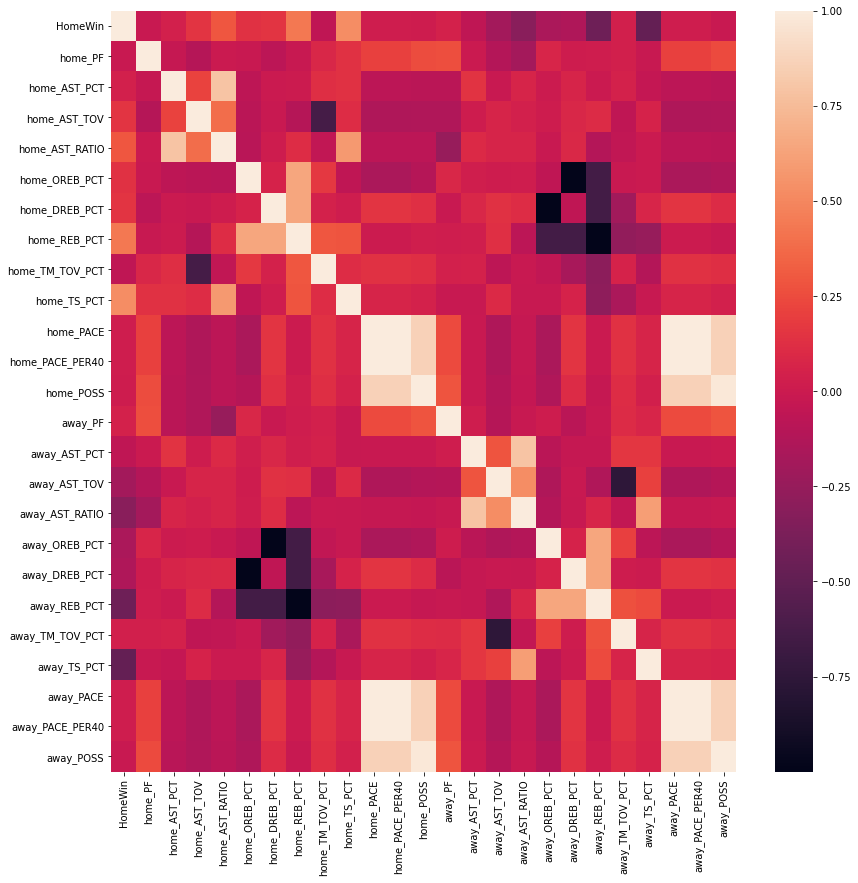

In [33]:
plt.figure(figsize = (14,14))
sns.heatmap(no_e_df.toPandas().corr())
plt.show()

In [34]:
corr_df = no_e_df.toPandas().corr()
j=0
for i in corr_df.columns:
    print(f"Correlation of {i} = {corr_df.iloc[0][j]}")
    j+=1

Correlation of HomeWin = 1.0
Correlation of home_PF = -0.008284735439198762
Correlation of home_AST_PCT = 0.04512517473790482
Correlation of home_AST_TOV = 0.15493191902642559
Correlation of home_AST_RATIO = 0.2908741385447218
Correlation of home_OREB_PCT = 0.13985806971408493
Correlation of home_DREB_PCT = 0.14934096292746155
Correlation of home_REB_PCT = 0.43301543883520854
Correlation of home_TM_TOV_PCT = -0.05905952204330835
Correlation of home_TS_PCT = 0.5251072389555801
Correlation of home_PACE = 0.016185270832408595
Correlation of home_PACE_PER40 = 0.01617025568799348
Correlation of home_POSS = 0.010319361211448828
Correlation of away_PF = 0.053666713047682495
Correlation of away_AST_PCT = -0.05971826802708149
Correlation of away_AST_TOV = -0.1903854079505966
Correlation of away_AST_RATIO = -0.3089610461479396
Correlation of away_OREB_PCT = -0.14947385344000336
Correlation of away_DREB_PCT = -0.13985276479550438
Correlation of away_REB_PCT = -0.4330060994760807
Correlation of aw

#### We'll drop some of these columns that have very extremely low correlations.

In [35]:
low_corr=[]
for i in range(len(corr_df.columns)):
    if abs(corr_df.iloc[0][i]) < .1:
        low_corr.append(corr_df.columns[i])

In [36]:
no_e_df = no_e_df.drop(*low_corr)

### Prepare data with VectorAssembler

In [37]:
from pyspark.ml.feature import VectorAssembler

In [38]:
inputCols = no_e_df.toPandas().drop('HomeWin', axis=1).columns.tolist()

In [39]:
va = VectorAssembler(inputCols = inputCols, outputCol = 'features')
va_df = va.transform(no_e_df)
va_df = va_df.select(['features', 'HomeWin'])

### Standardize Data

In [40]:
from pyspark.ml.feature import StandardScaler

In [41]:
train_test_split = va_df.randomSplit([0.8, 0.2], seed=76)
train_df = train_test_split[0]
test_df = train_test_split[1]

In [42]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeats')
train_scaled = scaler.fit(train_df).transform(train_df)
test_scaled = scaler.fit(train_df).transform(test_df)

### Modeling

In [43]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [44]:
lr = LogisticRegression(featuresCol='scaledFeats', labelCol='HomeWin', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_scaled)
lr_predictions = lr_model.transform(test_scaled)

In [45]:
lr_evaluator = BinaryClassificationEvaluator(labelCol='HomeWin')
lr_evaluator.evaluate(lr_predictions)

0.9066784175479826

### Get a dataframe of last 5 games advanced stats

In [46]:
# DF for competive window before playoff positioning locks
# team_adv = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Advanced',
#                                                    date_from_nullable='05/06/2021', date_to_nullable='05/14/2021').get_data_frames()[0]

In [47]:
# DF of last 5
team_adv = leaguedashteamstats.LeagueDashTeamStats(last_n_games=5, measure_type_detailed_defense='Advanced').get_data_frames()[0]

### Build some functoins to avoid a further mess of local variables than we already have

In [48]:
def nickname_to_id(nickname=''):
    return team_df[team_df['nickname'] == nickname].iloc[0][0]

def gen_data(nickname=''):
    return team_adv[team_adv['TEAM_ID'] == nickname_to_id(nickname)]

def away_cols(nickname=''):
    new_df = gen_data(nickname)
    new_df = new_df.rename(columns={'AST_TO': 'AST_TOV'})
    new_df = new_df.add_prefix('away_')
    return new_df
    
def home_cols(nickname=''):
    new_df = gen_data(nickname)
    new_df = new_df.rename(columns={'AST_TO': 'AST_TOV'})
    new_df = new_df.add_prefix('home_')
    return new_df

def matchup(home='', away=''):
    home_team = home_cols(home)
    away_team = away_cols(away)
    home_data = [i for i in no_e_df.columns if i in home_cols(home).columns]
    away_data = [i for i in no_e_df.columns if i in away_cols(away).columns]
    final_home = home_team[home_data].reset_index(drop=True)
    final_away = away_team[away_data].reset_index(drop=True)
    final_line = pd.concat([final_home, final_away], axis=1)
    return final_line

def winner(home='', away=''):
    match_df = matchup(home,away)
    spark_match = spark.createDataFrame(match_df)
    va = VectorAssembler(inputCols = spark_match.columns, outputCol = 'features')
    va_df = va.transform(spark_match)
    game = va_df.select('features')
    return game

#### Scale the data for the mathcup according to our training data

## 05/16/21 - Predict Trail Blazers vs. Nuggets 9:00PM Tip-Off, 12:45PM Prediction
* 1.0 indicates model predicts Home team win

In [53]:
lr_model.transform(scaler.fit(train_df).transform(winner('Trail Blazers', 'Nuggets'))).select('prediction').show()

+----------+
|prediction|
+----------+
|       1.0|
+----------+



#### Model predicts Trail Blazers to win.

## 05/16/21 - Predict Timberwolves vs. Mavericks 9:00PM Tip-Off, 12:45PM Prediction

In [56]:
lr_model.transform(scaler.fit(train_df).transform(winner('Timberwolves', 'Mavericks'))).select('prediction').show()

+----------+
|prediction|
+----------+
|       1.0|
+----------+



#### Model predicts Timberwolves to win.